In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt
from pandas_ml_common import Constant
from pandas_ml_utils import FeaturesAndLabels, Model
from pandas_ml_utils.ml.data.extraction import extract_with_post_processor
from pandas_ml_quant import pd, np, PostProcessedFeaturesAndLabels

# make experiments reproducable
import torch as t
t.manual_seed(0)

SYMBOL = "T"
START_DATE = "1995-01-01"

automatically imported pandas_ml_utils 0.1.5


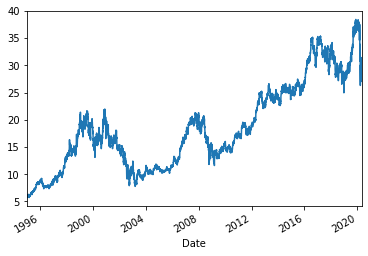

In [2]:
df = pd.fetch_yahoo(SYMBOL)[START_DATE:] if START_DATE is not None else pd.fetch_yahoo(SYMBOL)
df["Close"].plot()

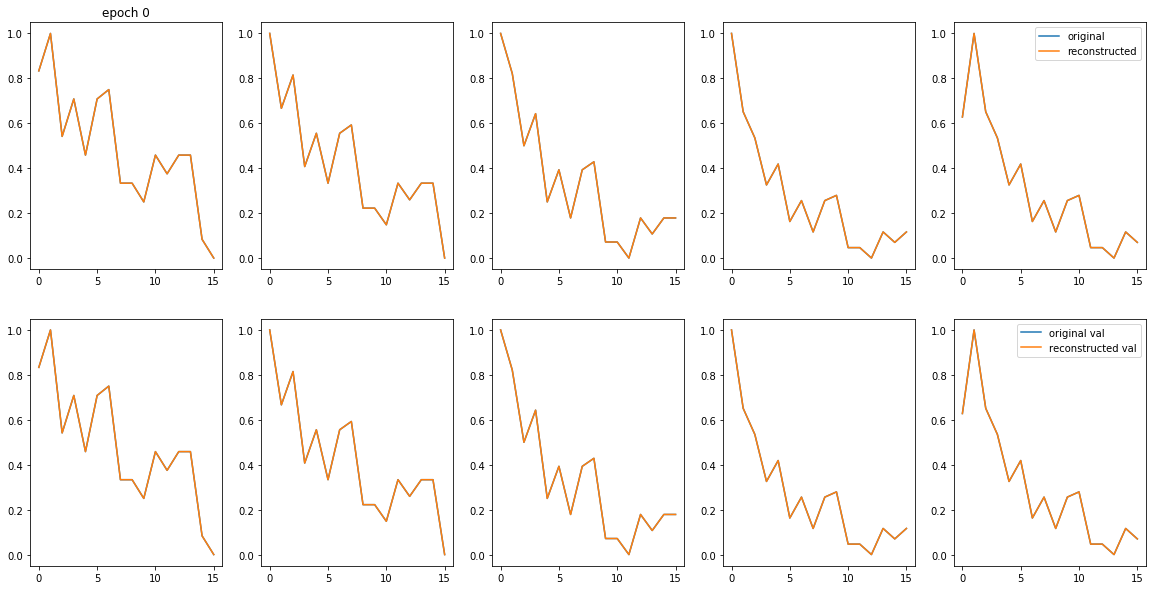

,Close_gaf
Date,
2020-04-27,"[[0.40202251690993157, 0.11765534120802174, 0...."
2020-04-28,"[[0.11848771266540398, 0.049362628064314684, -..."
2020-04-29,"[[1.0, 0.6020408163265302, 0.5459183673469387,..."
2020-04-30,"[[-0.4793835901707626, 0.5102040816326529, -0...."
2020-05-01,"[[-0.9037380258225742, -0.7271680015293189, 0...."


In [3]:
from pandas_ml_quant.analysis.encoders import np_inverse_gaf
from IPython.display import clear_output

def plot_callback(y, y_hat, y_val, y_hat_val, epoch):
    clear_output(wait=True)
    fig, ax = plt.subplots(2, 5, figsize=(20, 10))    
    ax[0, 0].set_title(f'epoch {epoch}')

    for i in range(5):
        _y = np_inverse_gaf(y[i])[0]
        _y_hat = np_inverse_gaf(y_hat[i])[0]

        _y_val = np_inverse_gaf(y_val[i])[0]
        _y_hat_val = np_inverse_gaf(y_hat_val[i])[0]
        
        ax[0, i].plot(_y, label="original")
        ax[0, i].plot(_y_hat, label="reconstructed")
        ax[1, i].plot(_y_val, label="original val")
        ax[1, i].plot(_y_hat_val, label="reconstructed val")
        
    ax[0, -1].legend()
    ax[1, -1].legend()
    plt.show()
            
f_n_l = FeaturesAndLabels(
    [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
    [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
    targets = [lambda df: df["Close"] > df["Close"].shift(16)]
)

(f, _), l, tg, w, gl = df._.extract(f_n_l)
label = l._.values

# plot and simulate a batch
plot_callback(label[:10], label[:10], label[:10], label[:10], 0)

f.tail()

In [8]:
import torch as t
import torch.nn as nn
from torch.optim import Adam, Adagrad, RMSprop
from pandas_ml_utils import FeaturesAndLabels, PytorchModel, AutoEncoderModel
from pandas_ml_utils.pytorch import Reshape
from torch.autograd import Variable


class ProductOfExperts(nn.Module):
    """Return parameters for product of independent experts.
    See https://arxiv.org/pdf/1410.7827.pdf for equations.
    @param mu: M x D for M experts
    @param logvar: M x D for M experts
    """
    def forward(self, mu, logvar, eps=1e-8):
        var       = t.exp(logvar) + eps
        # precision of i-th Gaussian expert at point x
        T         = 1. / (var + eps)
        pd_mu     = t.sum(mu * T, dim=0) / t.sum(T, dim=0)
        pd_var    = 1. / t.sum(T, dim=0)
        pd_logvar = t.log(pd_var + eps)
        return pd_mu, pd_logvar


class MVAELoss(nn.Module):
    
        
    def __init__(self, criterion=nn.MSELoss(), lambda_reconstruction=1.0, annealing_factor=1):
        super().__init__()
        self.criterion = criterion
        self.lambda_reconstruction = lambda_reconstruction
        self.annealing_factor = annealing_factor
        
    def forward(self, y_hat, y):
        # unpack y_hat
        y_hat, mu, logvar = y_hat
        
        reconstruction_loss = self.criterion(y_hat, y).sum()
        KLD = 0.5 * t.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        ELBO = t.mean(self.lambda_reconstruction * reconstruction_loss + self.annealing_factor * KLD)
        return ELBO

    def fofof(self):
        # todo this needs to be part of the training loop
        if epoch < args.annealing_epochs:
            # compute the KL annealing factor for the current mini-batch in the current epoch
            annealing_factor = (float(batch_idx + (epoch - 1) * N_mini_batches + 1) /
                                float(args.annealing_epochs * N_mini_batches))
        else:
            # by default the KL annealing factor is unity
            annealing_factor = 1.0

    

class MVAutoEncoder(nn.Module):

    def __init__(self, activation = nn.Tanh):
        super().__init__()
        self.activation = activation
        self.mu = [nn.Linear(4, 4), nn.Linear(4, 4)]
        self.sigma = [nn.Linear(4, 4), nn.Linear(4, 4)]
        self.experts = ProductOfExperts()
        
        self._encoder = nn.Sequential(
            nn.Dropout(0.1),
            nn.Conv2d(1, 16, 3, padding=1),
            activation(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            activation(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(4, 1, 3, padding=1),
            activation(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten()            
        )
        
        self._decoder = nn.Sequential(            
            Reshape(1, 2, 2),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(1, 4, 3, padding=1),
            activation(),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(4, 16, 3, padding=1),
            activation(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(16, 1, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):        
        if self.training:
            enc = self._encoder(x)
            
            # we need more then one mu and more then one sigma per node in the bottle neck
            # expected shape for mu and for sigma (modes, batch, latents) -> (2, -1, 4)
            mu, logvar = t.stack([m(enc) for m in self.mu]), t.stack([s(enc) for s in self.sigma])
            
            # product of distributions
            mu, logvar = self.experts(mu, logvar)
            
            # reparametrization trick to sample
            z = self._reparam(mu, logvar)
            
            # reconstruct
            y = self._decoder(z)
            
            return y, mu, logvar
        else:
            _x = x
            _x = self._encoder(_x)
            _x = self._decoder(_x)
            return _x
    
    def _reparam(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encoder(self, x):
        with t.no_grad():
            return self._encoder(t.from_numpy(x).float()).numpy()

    def decoder(self, x):
        with t.no_grad():
            return self._decoder(t.from_numpy(x).float()).numpy()



model = AutoEncoderModel(
    PytorchModel(
        FeaturesAndLabels(
            [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
            [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
        ),
        MVAutoEncoder,
        MVAELoss,
        Adam,
    ),
    [f"condensed{i}" for i in range(4)],
    lambda m: m.module.encoder,
    lambda m: m.module.decoder,
)

ae_fit = df.model.fit(
    model, 
    epochs=3, 
    batch_size=32, 
    # on_epoch=[plot_callback]
)

prediction                                   \
           condensed0 condensed1 condensed2 condensed3   
Date                                                     
2020-04-27   0.998344   0.998454   0.998321   0.998452   
2020-04-28   0.998705   0.998749   0.998717   0.998739   
2020-04-29   0.998730   0.998749   0.998763   0.998786   
2020-04-30   0.998750   0.998763   0.998742   0.998785   
2020-05-01   0.998743   0.998756   0.998722   0.998761   

                                                      feature  
                                                    Close_gaf  
Date                                                           
2020-04-27  [[0.40202251690993157, 0.11765534120802174, 0....  
2020-04-28  [[0.11848771266540398, 0.049362628064314684, -...  
2020-04-29  [[1.0, 0.6020408163265302, 0.5459183673469387,...  
2020-04-30  [[-0.4793835901707626, 0.5102040816326529, -0....  
2020-05-01  [[-0.9037380258225742, -0.7271680015293189, 0....

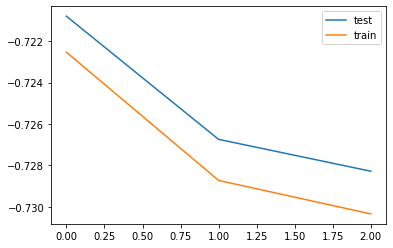

In [10]:
ae_fit.model.plot_loss()

ae_model = ae_fit.model
encoder_model = ae_model.as_encoder()
encoded = df.model.predict(encoder_model)
encoded.tail()

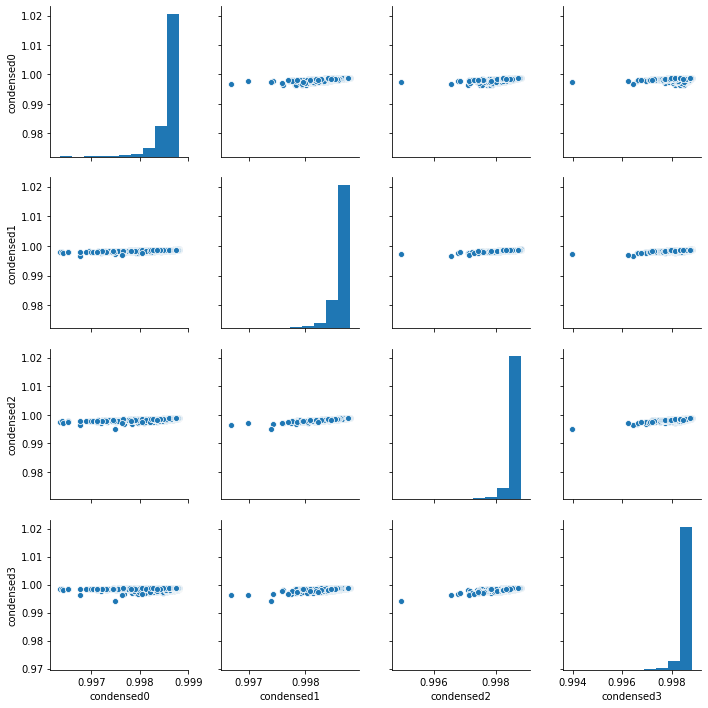

In [11]:
import seaborn as sns

sns.pairplot(encoded["prediction"])

prediction                                   \
           condensed0 condensed1 condensed2 condensed3   
Date                                                     
2020-04-27   0.017187  -0.087689  -0.268261   0.259990   
2020-04-28   0.143762  -0.052251  -0.122517   0.265918   
2020-04-29   0.050309  -0.024872   0.209449   0.269522   
2020-04-30  -0.164309   0.046916   0.158972   0.113579   
2020-05-01  -0.036500   0.118207   0.130078  -0.049207   

                                                      feature  
                                                    Close_gaf  
Date                                                           
2020-04-27  [[0.40202251690993157, 0.11765534120802174, 0....  
2020-04-28  [[0.11848771266540398, 0.049362628064314684, -...  
2020-04-29  [[1.0, 0.6020408163265302, 0.5459183673469387,...  
2020-04-30  [[-0.4793835901707626, 0.5102040816326529, -0....  
2020-05-01  [[-0.9037380258225742, -0.7271680015293189, 0....

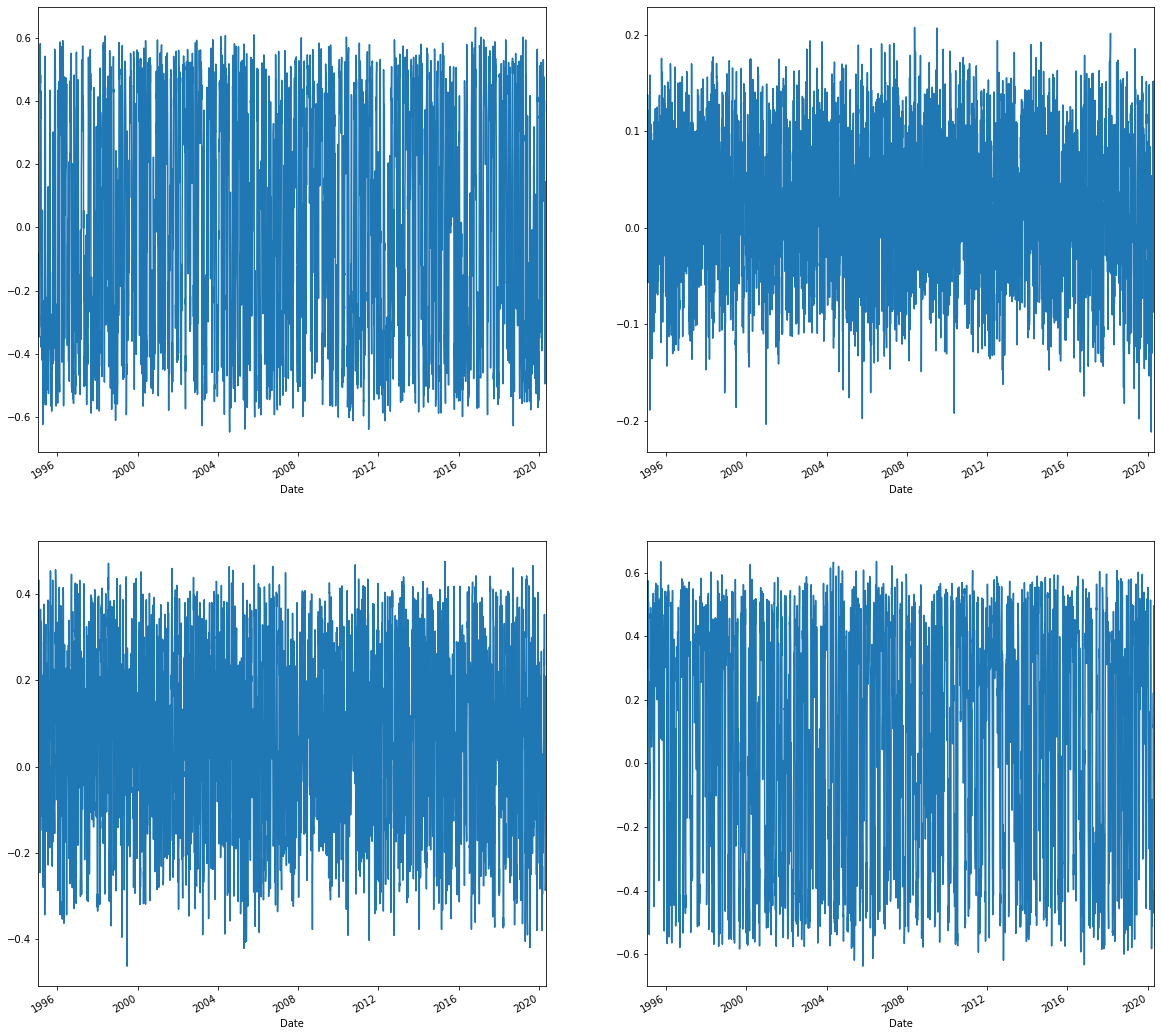

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax = ax.reshape(-1)

for i in range(4):
    encoded["prediction"].iloc[:,i].plot(ax=ax[i])
    
